In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

In [2]:
labels = [{'name':'pan card', 'id':1}, {'name':'not pan card', 'id':2}]

In [3]:
labels

[{'name': 'pan card', 'id': 1}, {'name': 'not pan card', 'id': 2}]

In [4]:
with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [5]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


In [6]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'

In [7]:
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!copy {PRETRAINED_MODEL_PATH+'\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\pipeline.config'} {MODEL_PATH+'\'+CUSTOM_MODEL_NAME}

A subdirectory or file Tensorflow\workspace\models\my_ssd_mobnet already exists.


The system cannot find the file specified.


In [8]:
!mkdir {r"C:\Users\rajan\Downloads\NewGen\Tensorflow\workspace\models\my_ssd_mobnet"}
!copy {r"C:\Users\rajan\Downloads\NewGen\Tensorflow\workspace\pre-trained-models\ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8\pipeline.config"} {r"C:\Users\rajan\Downloads\NewGen\Tensorflow\workspace\models\my_ssd_mobnet"}

A subdirectory or file C:\Users\rajan\Downloads\NewGen\Tensorflow\workspace\models\my_ssd_mobnet already exists.


        1 file(s) copied.


In [9]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [10]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [11]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [12]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
   

In [13]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [14]:
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [15]:
pipeline_config

model {
  ssd {
    num_classes: 2
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.01
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.997
          scale: true
          epsilon: 0.001
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      arg

In [16]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [17]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=3000""".format(APIMODEL_PATH, MODEL_PATH, CUSTOM_MODEL_NAME, MODEL_PATH, CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=3000


In [18]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [19]:
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-4')).expect_partial()

In [20]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [21]:
import cv2 
import numpy as np

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [ ]:
category_index

In [22]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [27]:
IMAGE_PATH = os.path.join(r"C:\Users\rajan\Downloads\NewGen\Tensorflow\workspace\images\test\PAN-CARD.jpg")

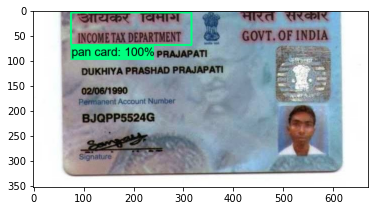

In [28]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()